# Merging labels according to centroid-distances
In this notebook we will merge labels in a label image according to their centroid-distances to each other. Labels close-by will be merged.

See also
* [Image.sc discussion](https://forum.image.sc/t/measure-distances-between-labels/79125)
* [Merging labels using napari-accelerated-pixel-and-object-classifiers](https://github.com/haesleinhuepf/napari-accelerated-pixel-and-object-classification#merging-objects)

In [1]:
import pyclesperanto_prototype as cle
from skimage.io import imread

For demonstration purposes, we use a modified version of the labels derived from the blobs example-image. We artificially introduce gaps between them.

cl.OCLArray([[ 0,  0,  0, ..., 45, 45, 45],
       [ 0,  0,  0, ..., 45, 45, 45],
       [ 0,  0,  0, ..., 45, 45, 45],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint32)
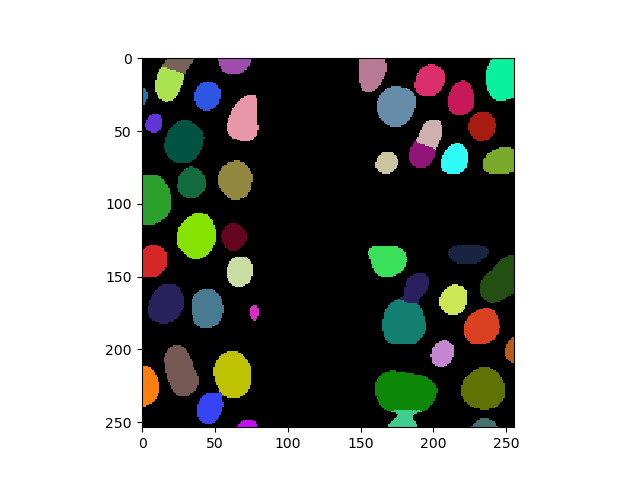

In [2]:
image = imread("../../data/blobs.tif")
image[:, 80:150] = 0
image[80:130, 100:] = 0

image = cle.asarray(image)
labels = cle.voronoi_otsu_labeling(image, spot_sigma=4, outline_sigma=3)
labels

From this image, we extract the coordinates of centroids. From these centroids, we can build a distance matrix. In this matrix, the distance from all centroids to all other centroids is computed. The diagonale is zero as it corresponds to the distance of one centroid to itself. Furthermore, the distance to background (first row and first colum) is also zero, as background is not considered for distance computation.

cl.OCLArray([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      , 199.36461 , ..., 245.29527 , 274.9624  ,
        306.2263  ],
       [  0.      , 199.36461 ,   0.      , ..., 321.00064 , 250.97119 ,
        249.23108 ],
       ...,
       [  0.      , 245.29527 , 321.00064 , ...,   0.      , 139.21213 ,
        186.94691 ],
       [  0.      , 274.9624  , 250.97119 , ..., 139.21213 ,   0.      ,
         48.239468],
       [  0.      , 306.2263  , 249.23108 , ..., 186.94691 ,  48.239468,
          0.      ]], dtype=float32)
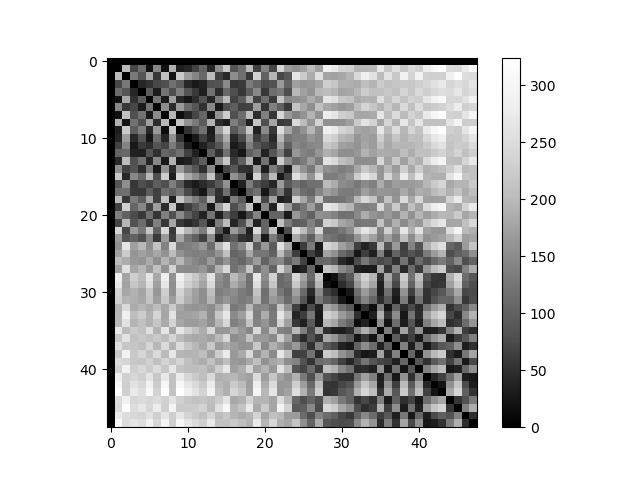
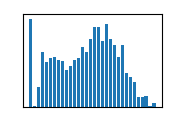

In [3]:
centroids = cle.centroids_of_labels(labels)

distance_matrix = cle.generate_distance_matrix(centroids, centroids)
distance_matrix

We can threshold this distance matrix with a given maximum distance. The result is a binary matrix.

cl.OCLArray([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 1]], dtype=uint8)
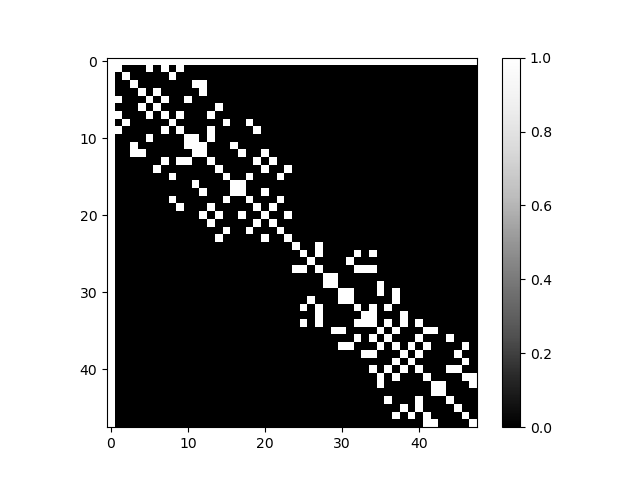
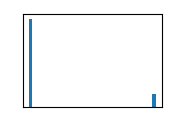

In [4]:
maximum_distance = 40

merge_matrix = distance_matrix <= maximum_distance
merge_matrix

If we werged labels with the background, all labels would be merged because all touch the background. In order to prevent this, we set the first row and column to zero.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)
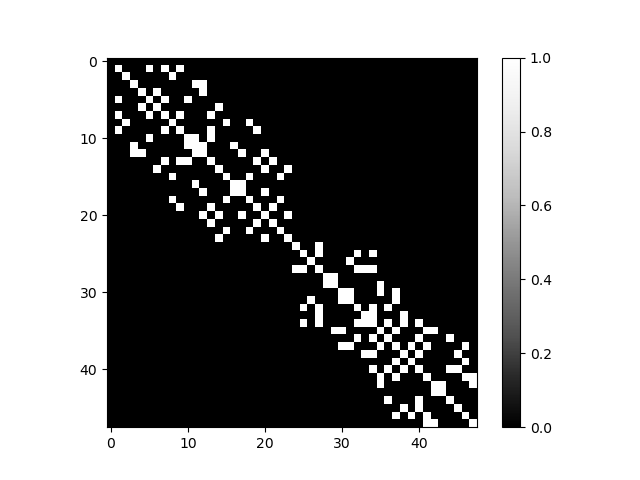
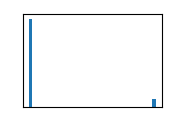

In [5]:
cle.set_column(merge_matrix, 0, 0)
cle.set_row(merge_matrix, 0, 0)

merge_matrix

Using the binary matrix above we can now merge the labels accordingly.

cl.OCLArray([[0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
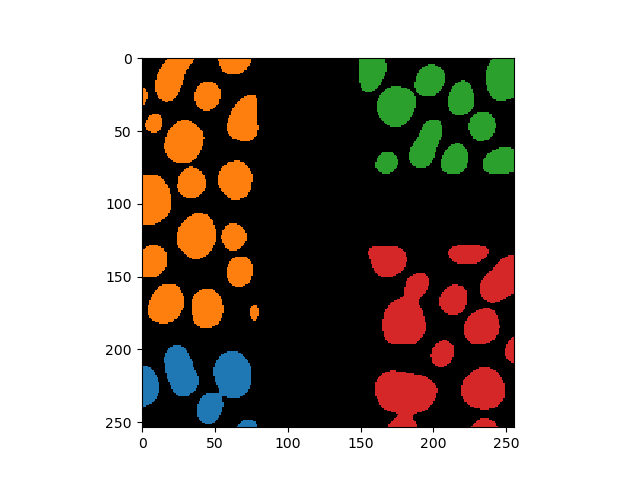

In [6]:
merged_labels = cle.merge_labels_according_to_touch_matrix(labels, merge_matrix)
merged_labels